Cargando archivo para refinamiento...
Imputando valores nulos y eliminando columnas vacías...
Columnas eliminadas por estar completamente vacías: ['SCORE.4', 'SCORE.5']
Eliminando columnas redundantes...
Verificando y tratando valores extremos en SCORE.1...
Normalizando SCORE.1 y SCORE.2...
Eliminando notación científica y limitando dígitos...
Columnas numéricas para formatear: ['SCORE.1', 'SCORE.2']
Validando formato numérico antes de guardar...
SCORE.1 muestra ejemplos: ['0.461627008636138813635341193731', '0.461627008636138813635341193731', '0.461627008636138813635341193731', '0.461627008636138813635341193731', '0.461627008636138813635341193731']
SCORE.2 muestra ejemplos: ['0', '0', '0', '0', '0']
Eliminando duplicados basados en columnas clave...
Validando integridad de datos...
Generando visualizaciones...


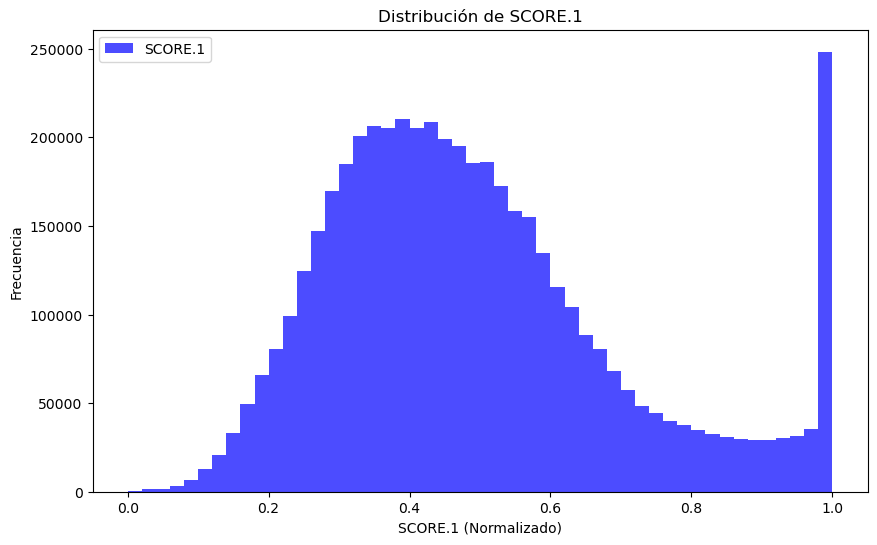

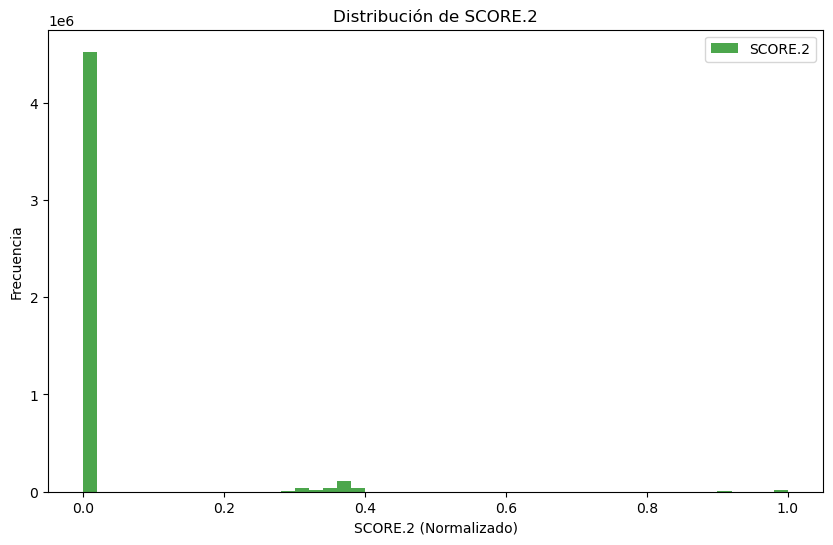

Guardando el archivo refinado...
Archivo refinado guardado en C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2_refined.csv


In [2]:
# Cleaning of the second block of the BIOGRID file while preserving compatibility for merging
# Limpieza del segundo bloque del archivo BIOGRID conservanndo compatibilidad para fusion

# I follow the cleaning criteria applied in block 1 but adjusted to block 2
# Sigo el criterio de limpieza aplicado en el bloque 1 pero ajustado al bloque 2

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

# Global setting to avoid scientific notation
# Configuración global para evitar notación científica
pd.options.display.float_format = '{:.12g}'.format

# Path of the file to be processed
# Ruta del archivo a procesar
input_file = r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2.csv'
output_file = r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2_refined.csv'

# Read the processed file
# Leer el archivo procesado
print("Cargando archivo para refinamiento...")
data = pd.read_csv(input_file, low_memory=False)

# Step 1: Handling null values in key columns
# Paso 1: Manejo de valores nulos en columnas clave
print("Imputando valores nulos y eliminando columnas vacías...")

# Fill null values in key columns
# Rellenar valores nulos en columnas clave
if 'ALIASES' in data.columns:
    data['ALIASES'].fillna("UNKNOWN", inplace=True)

if 'SCORE.2' in data.columns:
    data['SCORE.2'].fillna(0, inplace=True)

# Eliminate completely null columns
# Eliminar columnas completamente nulas
columns_to_drop = [col for col in data.columns if data[col].isnull().all()]
print(f"Columnas eliminadas por estar completamente vacías: {columns_to_drop}")
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Step 2: Eliminate redundant columns
# Paso 2: Eliminar columnas redundantes
print("Eliminando columnas redundantes...")
redundant_columns = ['SOURCE', 'SCORE.3', 'ORGANISM_ID', '#SCREEN_ID']
data.drop(columns=redundant_columns, inplace=True, errors='ignore')

# Step 3: Review and treat outliers in SCORE.1
# Paso 3: Revisar y tratar valores extremos en SCORE.1
print("Verificando y tratando valores extremos en SCORE.1...")
if 'SCORE.1' in data.columns:
    q1 = data['SCORE.1'].quantile(0.25)
    q3 = data['SCORE.1'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Replace extreme values by reasonable limits
    # Reemplazar valores extremos por límites razonables
    data['SCORE.1'] = data['SCORE.1'].apply(
        lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
    )

# Step 4: Standardize SCORE.1 and SCORE.2
# Paso 4: Normalizar SCORE.1 y SCORE.2
print("Normalizando SCORE.1 y SCORE.2...")
scaler = MinMaxScaler()

# Normalizar SCORE.1 si es numérico
if 'SCORE.1' in data.columns:
    data['SCORE.1'] = scaler.fit_transform(data[['SCORE.1']])

# Manejo y normalización de SCORE.2
if 'SCORE.2' in data.columns:
    data['SCORE.2'] = pd.to_numeric(data['SCORE.2'], errors='coerce')  # Convertir valores no numéricos a NaN
    median_score2 = data['SCORE.2'].median()  # Calcular la mediana para imputar valores faltantes
    data['SCORE.2'].fillna(median_score2, inplace=True)  # Rellenar valores no numéricos con la mediana
    data['SCORE.2'] = scaler.fit_transform(data[['SCORE.2']])

# Step 5: Eliminate scientific notation and limit to 30 digits
# Paso 5: Eliminar notación científica y limitar a 30 dígitos
print("Eliminando notación científica y limitando dígitos...")
def format_numeric_columns(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: f"{x:.30g}" if isinstance(x, (int, float)) else x)
    return df

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
print(f"Columnas numéricas para formatear: {list(numeric_columns)}")
data = format_numeric_columns(data, numeric_columns)

# Explicit validation before saving
# Validación explícita antes de guardar
print("Validando formato numérico antes de guardar...")
for column in numeric_columns:
    print(f"{column} muestra ejemplos: {data[column].head(5).tolist()}")

# Step 6: Remove duplicates based on key columns
# Paso 6: Eliminar duplicados basados en columnas clave
print("Eliminando duplicados basados en columnas clave...")
columns_to_consider = ['IDENTIFIER_ID', 'IDENTIFIER_TYPE', 'OFFICIAL_SYMBOL', 'SCORE.1', 'SCORE.2']
data.drop_duplicates(subset=columns_to_consider, inplace=True)

# Step 7: Validate final integrity
# Paso 7: Validar integridad final
print("Validando integridad de datos...")
data.fillna("UNKNOWN", inplace=True)

# Step 8: Visualizations
# Paso 8: Visualizaciones
print("Generando visualizaciones...")
plt.figure(figsize=(10, 6))

# Histogram of SCORE.1
# Histograma de SCORE.1
plt.hist(data['SCORE.1'].astype(float), bins=50, alpha=0.7, label='SCORE.1', color='blue')
plt.title('Distribución de SCORE.1')
plt.xlabel('SCORE.1 (Normalizado)')
plt.ylabel('Frecuencia')
plt.legend()
plt.savefig('score1_distribution_block2.png')
plt.show()

# Histogram of SCORE.2
# Histograma de SCORE.2
plt.figure(figsize=(10, 6))
plt.hist(data['SCORE.2'].astype(float), bins=50, alpha=0.7, label='SCORE.2', color='green')
plt.title('Distribución de SCORE.2')
plt.xlabel('SCORE.2 (Normalizado)')
plt.ylabel('Frecuencia')
plt.legend()
plt.savefig('score2_distribution_block2.png')
plt.show()

# Step 9: Save refined file
# Paso 9: Guardar archivo refinado
print("Guardando el archivo refinado...")
data.to_csv(output_file, index=False)

print(f"Archivo refinado guardado en {output_file}")


In [3]:
# I check again and generate a report with file characteristics, check for duplicates, etc.
# Reviso nuevamente y genero  un reporte con las caracteristicas del archivo, revision de duplicados, etc

# Path of the file to be analyzed
# Ruta del archivo a analizar
file_to_analyze = r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2_refined.csv'
report_file = r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2_refined_report.txt'

# Read the file
# Leer el archivo
print("Cargando el archivo para análisis...")
data = pd.read_csv(file_to_analyze, low_memory=False)

# Initialize report
# Inicializar reporte
report = []

# Step 1: General file information
# Paso 1: Información general del archivo
report.append("=== Información general ===")
report.append(f"Número de filas: {data.shape[0]}")
report.append(f"Número de columnas: {data.shape[1]}")

# Step 2: Data types and columns
# Paso 2: Tipos de datos y columnas
report.append("\n=== Tipos de datos y columnas ===")
report.append(data.dtypes.to_string())

# Step 3: Duplicates
# Paso 3: Duplicados
duplicates_count = data.duplicated().sum()
report.append(f"\n=== Duplicados ===")
report.append(f"Número de duplicados: {duplicates_count}")

# Step 4: Null values
# Paso 4: Valores nulos
null_summary = data.isnull().sum()
columns_with_nulls = null_summary[null_summary > 0]
report.append("\n=== Valores nulos ===")
if not columns_with_nulls.empty:
    report.append(columns_with_nulls.to_string())
else:
    report.append("No hay valores nulos.")

# Step 5: Descriptive statistics
# Paso 5: Estadísticas descriptivas
report.append("\n=== Estadísticas descriptivas ===")
report.append(data.describe(include='all', percentiles=[0.25, 0.5, 0.75]).to_string())

# Step 6: Unique values per column
# Paso 6: Valores únicos por columna
report.append("\n=== Valores únicos por columna ===")
unique_counts = data.nunique()
report.append(unique_counts.to_string())

# Step 7: File size
# Paso 7: Tamaño del archivo
file_size_mb = data.memory_usage(index=True).sum() / (1024 ** 2)
report.append("\n=== Tamaño del archivo ===")
report.append(f"Tamaño en memoria: {file_size_mb:.2f} MB")

# Save report
# Guardar reporte
print("Generando reporte...")
with open(report_file, 'w') as file:
    file.write("\n".join(report))

print(f"Reporte generado y guardado en {report_file}")

Cargando el archivo para análisis...
Generando reporte...
Reporte generado y guardado en C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2_refined_report.txt
